In [ ]:
! pip install mlflow
! pip instal awscli
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

mlflow.set_tracking_uri('http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/')
nltk.download('stopwords')
nltk.download('wordnet')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
print(df.shape)
print(df.isna().sum())

(37249, 2)
clean_comment    100
category           0
dtype: int64


In [4]:
df.dropna(inplace=True)

In [5]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

350


In [6]:
df=df[~(df['clean_comment'].str.strip()=='')]

In [7]:
# Pre-Processing the data
def preprocess_comment(comment):
  # Lower the string
  comment=comment.lower()

  # Removing the trailing and leading spaces
  comment=comment.strip()

  # Removing the newline charecter
  comment=re.sub(r'\n',' ',comment)

  # Removing alpha numeric charecter , Except the punctuations
  comment= re.sub(r'[^A-Za-z0-9\s!?.,]','',comment)

  # Removing the stop words
  stop_words=set(stopwords.words('english'))-{'not','but','however','no','yet'}
  comment=' '.join([word for word in comment.split()if word not in stop_words])

  # Lemmatize the words
  lemmatizer=WordNetLemmatizer()
  comment=' '.join([lemmatizer.lemmatize(word)for word in comment.split()])

  return comment

In [8]:
df['clean_comment']=df['clean_comment'].apply(preprocess_comment)

In [9]:

X=df['clean_comment']
y=df['category']

In [10]:
X.shape

(36793,)

In [ ]:
!pip install awscli
!pip install boto3

In [ ]:
! aws configure

In [15]:
mlflow.set_experiment('E1 RF Baseline')

2025/03/07 17:04:57 INFO mlflow.tracking.fluent: Experiment with name 'E1 RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://om-mlflow-bucket/848107492997068804', creation_time=1741367097691, experiment_id='848107492997068804', last_update_time=1741367097691, lifecycle_stage='active', name='E1 RF Baseline', tags={}>

2025/03/07 17:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/848107492997068804/runs/242d1ef0e4f74e75a1e94d40e6cdb210
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/848107492997068804
Accuracy: 0.6469629025682837


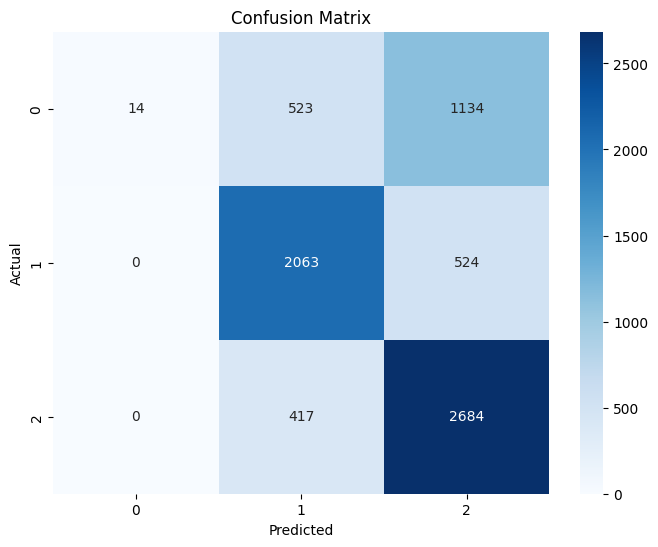

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

vectorizer=CountVectorizer(max_features=10000)
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    mlflow.log_param('vectorizer_type','CountVectorizer')
    mlflow.log_param('vectorizer_max_features',vectorizer.max_features)

    n_estimators=200
    max_depth=15

    mlflow.log_param('n_estimators',n_estimators)
    mlflow.log_param('max_depth',max_depth)

    model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,random_state=42)
    model.fit(X_train,y_train)

    y_pred=model.predict(X_test)

    accuracy=accuracy_score(y_test,y_pred)
    mlflow.log_metric('accuracy',accuracy)

    classification_rep=classification_report(y_test,y_pred,output_dict=True)

    for label,metrics in classification_rep.items():
        if isinstance (metrics,dict):
            for metric,value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}",value)

   # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("/content/confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("/content/dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")




In [17]:
# New Experiment
mlflow.set_experiment("E2 - BoW vs TfIdf")

2025/03/07 17:07:30 INFO mlflow.tracking.fluent: Experiment with name 'E2 - BoW vs TfIdf' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://om-mlflow-bucket/166716023712816921', creation_time=1741367250208, experiment_id='166716023712816921', last_update_time=1741367250208, lifecycle_stage='active', name='E2 - BoW vs TfIdf', tags={}>

In [18]:

# Step 1: Function to run the experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Step 2: Vectorization

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# Step 6: Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")


2025/03/07 17:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 1)_RandomForest at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921/runs/2d228c7e68b845da8a26050653a4f58c
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921


2025/03/07 17:08:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 1)_RandomForest at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921/runs/9092bc158a3a43ca9361f9f8d67c8617
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921


2025/03/07 17:08:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 2)_RandomForest at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921/runs/f40b01726029469a8f9086336ebffd08
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921


2025/03/07 17:08:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 2)_RandomForest at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921/runs/497d169c422b451499ac4d36857aeccc
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921


2025/03/07 17:09:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run BoW_(1, 3)_RandomForest at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921/runs/97ff7cc1daeb44bb9b3c1fa3bfcecdc5
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921


2025/03/07 17:09:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TF-IDF_(1, 3)_RandomForest at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921/runs/522fc380795f41fcb1228e1cd94af4a7
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/166716023712816921


In [19]:
# Set or create an experiment
mlflow.set_experiment("E3 - TfIdf Trigram max_features")

2025/03/07 17:09:30 INFO mlflow.tracking.fluent: Experiment with name 'E3 - TfIdf Trigram max_features' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://om-mlflow-bucket/265601057251774239', creation_time=1741367370281, experiment_id='265601057251774239', last_update_time=1741367370281, lifecycle_stage='active', name='E3 - TfIdf Trigram max_features', tags={}>

In [20]:
# Step 1: Function to run the experiment
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)  # Trigram setting

    # Step 2: Vectorization using TF-IDF with varying max_features


    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"TFIDF_Trigrams_max_features_{max_features}")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, max_features={max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, max_features={max_features}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_{max_features}")

# Step 6: Test various max_features values
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)

2025/03/07 17:09:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_1000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/9bd8c3cc9c224efca8daa20ad1a2e30b
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:10:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_2000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/85b2b176913c4ab8925d69f1cb875dad
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:10:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_3000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/09997b4744e6423982f3d817c0ba5016
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:10:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_4000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/02615625c28a4fbd87255aee02d3c8b9
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:11:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_5000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/503cf0a8453a4dadb6547ab79269b4d4
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:11:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_6000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/1772fd84af834d319b51ec134ab8ecb6
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:11:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_7000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/d74a2c4e69474027a0201a0ba50e5941
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:12:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_8000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/1f90e6a9c7cb4f6dad58dc5d9745124e
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:12:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_9000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/d4992d413c7f4abbbfbb822546892ba9
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


2025/03/07 17:12:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run TFIDF_Trigrams_max_features_10000 at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239/runs/7c7db4df0e754411ba3d9cf9b06e4a44
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/265601057251774239


In [21]:
# Set or create an experiment
mlflow.set_experiment("E4 - Handling Imbalanced Data")

2025/03/07 17:12:56 INFO mlflow.tracking.fluent: Experiment with name 'E4 - Handling Imbalanced Data' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://om-mlflow-bucket/146411124476787329', creation_time=1741367576089, experiment_id='146411124476787329', last_update_time=1741367576089, lifecycle_stage='active', name='E4 - Handling Imbalanced Data', tags={}>

In [22]:
# Step 1: Function to run the experiment
def run_imbalanced_experiment(imbalance_method):
    ngram_range = (1, 3)  # Trigram setting
    max_features = 10000  # Set max_features to 1000 for TF-IDF

    # Step 4: Train-test split before vectorization and resampling
    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    # Step 2: Vectorization using TF-IDF, fit on training data only
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_train_vec = vectorizer.fit_transform(X_train)  # Fit on training data
    X_test_vec = vectorizer.transform(X_test)  # Transform test data

    # Step 3: Handle class imbalance based on the selected method (only applied to the training set)
    if imbalance_method == 'class_weights':
        # Use class_weight in Random Forest
        class_weight = 'balanced'
    else:
        class_weight = None  # Do not apply class_weight if using resampling

        # Resampling Techniques (only apply to the training set)
        if imbalance_method == 'oversampling':
            smote = SMOTE(random_state=42)
            X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_train_vec, y_train = adasyn.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'undersampling':
            rus = RandomUnderSampler(random_state=42)
            X_train_vec, y_train = rus.fit_resample(X_train_vec, y_train)
        elif imbalance_method == 'smote_enn':
            smote_enn = SMOTEENN(random_state=42)
            X_train_vec, y_train = smote_enn.fit_resample(X_train_vec, y_train)

    # Step 5: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"Imbalance_{imbalance_method}_RandomForest_TFIDF_Trigrams")
        mlflow.set_tag("experiment_type", "imbalance_handling")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with TF-IDF Trigrams, imbalance handling method={imbalance_method}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", "TF-IDF")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("imbalance_method", imbalance_method)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, class_weight=class_weight)
        model.fit(X_train_vec, y_train)

        # Step 6: Make predictions and log metrics
        y_pred = model.predict(X_test_vec)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: TF-IDF Trigrams, Imbalance={imbalance_method}")
        confusion_matrix_filename = f"confusion_matrix_{imbalance_method}.png"
        plt.savefig(confusion_matrix_filename)
        mlflow.log_artifact(confusion_matrix_filename)
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_tfidf_trigrams_imbalance_{imbalance_method}")

# Step 7: Run experiments for different imbalance methods
imbalance_methods = ['class_weights', 'oversampling', 'adasyn', 'undersampling', 'smote_enn']

for method in imbalance_methods:
    run_imbalanced_experiment(method)


2025/03/07 17:13:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_class_weights_RandomForest_TFIDF_Trigrams at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329/runs/311975bee82243e086e7eda60e30a517
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329


2025/03/07 17:13:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_oversampling_RandomForest_TFIDF_Trigrams at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329/runs/1581dfdf301c45feaafca7b1f8bf95b5
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329


2025/03/07 17:14:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_adasyn_RandomForest_TFIDF_Trigrams at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329/runs/0a3d9d11ce5b4d2a8989d792e5ab0c5d
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329


2025/03/07 17:14:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_undersampling_RandomForest_TFIDF_Trigrams at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329/runs/ff0e51b82dbe4a28ad72c46ed2013144
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329


2025/03/07 17:15:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Imbalance_smote_enn_RandomForest_TFIDF_Trigrams at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329/runs/c73552da971d4377b7a08bd7bbde3ddf
🧪 View experiment at: http://ec2-100-26-36-125.compute-1.amazonaws.com:5000/#/experiments/146411124476787329


In [ ]:
df.to_csv('reddit_processed.csv',index=False)